<a href="https://colab.research.google.com/github/kumarchandan/100days/blob/master/EVA4_S4_MNIST_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Assignment**

- 99.4% validation accuracy
- Less than 20k Parameters
- You can use anything from above you want. 
- Less than 20 Epochs
- No fully connected layer
- To learn how to add different things we covered in this session, you can refer to this code: https://www.kaggle.com/enwei26/mnist-digits-pytorch-cnn-99 (Links to an external site.) DONT COPY ARCHITECTURE, JUST LEARN HOW TO INTEGRATE THINGS LIKE DROPOUT, BATCHNORM, ETC.


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),   # in=28, out=28 , rf=3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            
            nn.Conv2d(8, 16, 3, padding=1),  # in=28, out=28,  rf=5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.MaxPool2d(2, 2),              # in=28, out=14,  rf=10
            nn.Dropout(0.10)
        )

        # Second Conv block
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), # in=14 out=14, rf=12
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 16, 3, padding=1), # in=14, out=14, rf=14
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.MaxPool2d(2, 2),              # in=14, out=7, rf=28
            nn.Dropout(0.10)
        )

        # Third Conv Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 3),           # in=7, out=5, rf=30
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 16, 3),            # in=5, out=3, rf=32
            nn.AdaptiveAvgPool2d(1),         # in=3x3x32, out=1x1x32

            nn.Conv2d(16, 10, 1),            # in=1x1x32, out=1x1x10   # 1x1 works as FC layer here
        )          

    def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)

      x = x.view(-1, 10)
      x = F.log_softmax(x)
      return x


In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4           [-1, 16, 28, 28]           1,168
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
             ReLU-10           [-1, 16, 14, 14]               0
      BatchNorm2d-11           [-1, 16, 14, 14]              32
           Conv2d-12           [-1, 16, 14, 14]           2,320
             ReLU-13           [-1, 16, 14, 14]               0
      BatchNorm2d-14           [-1, 16,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    running_loss = 0    # for plotting per epoch
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss = running_loss + loss.item()
        pbar.set_description(desc= f'Epoch={epoch} loss={loss.item()} batch_id={batch_idx}')
    return running_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # `output` is the model prediction (what the model predicted on giving an image/data)
            # `target` is the actual label of the image
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (correct / len(test_loader.dataset))

In [10]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# for plotting graph
epoch_loss = []
test_acc = []

for epoch in range(1, 20):
    run_loss = train(model, device, train_loader, optimizer, epoch)
    test_ac = test(model, device, test_loader)
    # for plotting graph
    test_acc.append(test_ac)
    epoch_loss.append(run_loss / batch_size)


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9839/10000 (98.39%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9899/10000 (98.99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9917/10000 (99.17%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9895/10000 (98.95%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9929/10000 (99.29%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9929/10000 (99.29%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9931/10000 (99.31%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9927/10000 (99.27%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9924/10000 (99.24%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9935/10000 (99.35%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9934/10000 (99.34%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9928/10000 (99.28%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)



Epoch=19 loss=0.001856297254562378 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]



Test set: Average loss: 0.0185, Accuracy: 9933/10000 (99.33%)



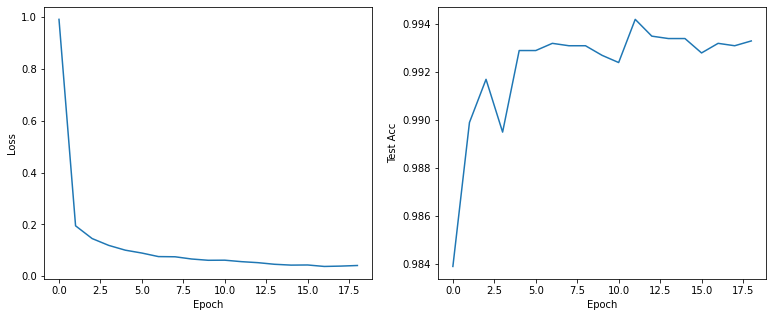

In [13]:
# Epoch: 12, Accuracy: 9942/10000 (99.42%)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss.png')

# 2nd image
plt.subplot(132)
plt.plot(test_acc)
plt.xlabel('Epoch')
plt.ylabel('Test Acc')
plt.savefig('loss.png')
plt.show()
